In [1]:
from models import model_softm, model_diri
from utils import *
import torch.multiprocessing as mp
import torch.optim as optim 

import torchvision
from torchvision import datasets, transforms

import math

mnist_trainset = datasets.MNIST(root='./data_train', train=True, download=True, transform=transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))]))
mnist_testset = datasets.MNIST(root='./data_test', train=False, download=True, transform=transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))]))


In [2]:
torch.manual_seed(0)
world_size = 2
mp.spawn(
    runmain,
    args=[model_diri, mnist_trainset, mnist_testset, world_size, 20],
    nprocs=world_size
)


[W socket.cpp:558] [c10d] The client socket cannot be initialized to connect to [localhost]:29500 (errno: 97 - Address family not supported by protocol).
[W socket.cpp:401] [c10d] The server socket cannot be initialized on [::]:29500 (errno: 97 - Address family not supported by protocol).
[W socket.cpp:558] [c10d] The client socket cannot be initialized to connect to [localhost]:29500 (errno: 97 - Address family not supported by protocol).
[W socket.cpp:558] [c10d] The client socket cannot be initialized to connect to [localhost]:29500 (errno: 97 - Address family not supported by protocol).
[W socket.cpp:558] [c10d] The client socket cannot be initialized to connect to [localhost]:29500 (errno: 97 - Address family not supported by protocol).


Train Epoch: 1 [0/60000 (0%)]	Loss: 2.140532
Train Epoch: 1 [3200/60000 (11%)]	Loss: 1.458439
Train Epoch: 1 [6400/60000 (21%)]	Loss: 1.419623
Train Epoch: 1 [9600/60000 (32%)]	Loss: 1.005490
Train Epoch: 1 [12800/60000 (43%)]	Loss: 1.173349
Train Epoch: 1 [16000/60000 (53%)]	Loss: 0.748498
Train Epoch: 1 [19200/60000 (64%)]	Loss: 0.667913
Train Epoch: 1 [22400/60000 (75%)]	Loss: 0.521103
Train Epoch: 1 [25600/60000 (85%)]	Loss: 0.783192
Train Epoch: 1 [28800/60000 (96%)]	Loss: 0.634389
Test average loss: 0.11906005859375, correct predictons: 9594, total: 10000, accuracy: 95.94% 

Train Epoch: 2 [0/60000 (0%)]	Loss: 0.801776
Train Epoch: 2 [3200/60000 (11%)]	Loss: 0.808624
Train Epoch: 2 [6400/60000 (21%)]	Loss: 0.666755
Train Epoch: 2 [9600/60000 (32%)]	Loss: 0.674131
Train Epoch: 2 [12800/60000 (43%)]	Loss: 0.529305
Train Epoch: 2 [16000/60000 (53%)]	Loss: 0.514869
Train Epoch: 2 [19200/60000 (64%)]	Loss: 0.602128
Train Epoch: 2 [22400/60000 (75%)]	Loss: 0.515562
Train Epoch: 2 [2560

/scratch365/kho2/models.py:13: UserWarning: Specified kernel cache directory could not be created! This disables kernel caching. Specified directory is /tmpscratch/kho2/.cache/torch/kernels. This warning will appear only once per process. (Triggered internally at  ../aten/src/ATen/native/cuda/jit_utils.cpp:860.)
  lnD = torch.lgamma(S_alpha) - torch.sum(torch.lgamma(alp_til), 1, keepdim=True)
/scratch365/kho2/models.py:13: UserWarning: Specified kernel cache directory could not be created! This disables kernel caching. Specified directory is /tmpscratch/kho2/.cache/torch/kernels. This warning will appear only once per process. (Triggered internally at  ../aten/src/ATen/native/cuda/jit_utils.cpp:860.)
  lnD = torch.lgamma(S_alpha) - torch.sum(torch.lgamma(alp_til), 1, keepdim=True)


Train Epoch: 14 [28800/60000 (96%)]	Loss: 0.648517
Test average loss: 0.110771875, correct predictons: 9790, total: 10000, accuracy: 97.9% 

Train Epoch: 15 [0/60000 (0%)]	Loss: 0.487082
Train Epoch: 15 [3200/60000 (11%)]	Loss: 1.136097
Train Epoch: 15 [6400/60000 (21%)]	Loss: 0.274403
Train Epoch: 15 [9600/60000 (32%)]	Loss: 0.558867
Train Epoch: 15 [12800/60000 (43%)]	Loss: 0.394700
Train Epoch: 15 [16000/60000 (53%)]	Loss: 1.867697
Train Epoch: 15 [19200/60000 (64%)]	Loss: 0.733503
Train Epoch: 15 [22400/60000 (75%)]	Loss: 0.817495
Train Epoch: 15 [25600/60000 (85%)]	Loss: 0.389362
Train Epoch: 15 [28800/60000 (96%)]	Loss: 0.534360
Test average loss: 0.103368896484375, correct predictons: 9786, total: 10000, accuracy: 97.86% 

Train Epoch: 16 [0/60000 (0%)]	Loss: 0.532520
Train Epoch: 16 [3200/60000 (11%)]	Loss: 0.613450
Train Epoch: 16 [6400/60000 (21%)]	Loss: 0.615940
Train Epoch: 16 [9600/60000 (32%)]	Loss: 0.635079
Train Epoch: 16 [12800/60000 (43%)]	Loss: 0.248607
Train Epoch: 

In [3]:
#Check test samples accuracy
import torch
network = model_diri()
network.load_state_dict(torch.load('model_diri_clip.pt'), strict=False)
network.eval()

all_mnist_testset = torch.unsqueeze(mnist_testset.data, 1).float()

output = network(all_mnist_testset).data + 1
pred = output.max(1, keepdim=True)[1].flatten()
 
S = torch.sum(output, 1, keepdim=True)
b = output/S
u = 10/S

correct_mask = (mnist_testset.targets == pred)
sum(correct_mask).item()/len(correct_mask)

0.9702

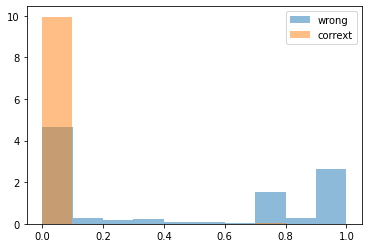

In [6]:
import matplotlib.pyplot as plt
plt.hist(u[~correct_mask].flatten().numpy(), density=True, alpha=0.5, label='wrong')
plt.hist(u[correct_mask].flatten().numpy(), density=True, alpha=0.5, label='corrext')
plt.legend()
plt.show()

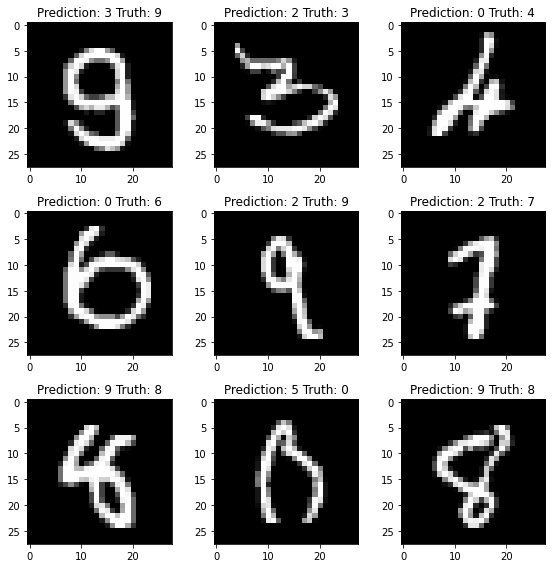

In [7]:
#Looking at some wrong examples
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(8,8))
for i, (example_data, example_targets) in enumerate(zip(mnist_testset.data[~correct_mask], mnist_testset.targets[~correct_mask])):
        example_data = example_data.unsqueeze_(0).float()
        if i >= 3*3: break
        plt.subplot(3,3,i+1)
        plt.tight_layout()
        plt.imshow(example_data.permute(1, 2, 0), cmap='gray')
        with torch.no_grad():
            prediction = network(example_data).data.max(1, keepdim=True)[1].item()
            plt.title("Prediction: {} Truth: {}".format(prediction, example_targets, fontsize=18))

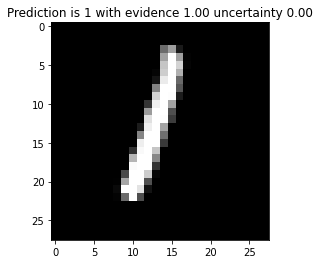

In [19]:
from IPython import display
import time
digi_one = mnist_testset[5][0]
evidence, unc, angles, rotated_pics, prediction = [], [], [], [], []
for angle in range(10, 190, 10):
    example_data_rotated = transforms.functional.rotate(digi_one, angle=angle)
    plt.imshow(example_data_rotated.permute(1, 2, 0), cmap='gray')
    

    output = network(example_data_rotated).data + 1
    pred = output.max(1, keepdim=True)[1].flatten()
    S = torch.sum(output, 1, keepdim=True)
    b = output/S
    u = 10/S

    plt.title(f'Prediction is {pred.item()} with evidence {b.max().flatten().item():0.2f} uncertainty {u.flatten().item():0.2f}')
    
    
    evidence.append(b.max().flatten().item())
    unc.append(u.flatten().item())
    angles.append(angle)
    rotated_pics.append(example_data_rotated)
    prediction.append(pred.item())
    
    display.display(plt.gcf())
    display.clear_output(wait=True)
    time.sleep(.1)

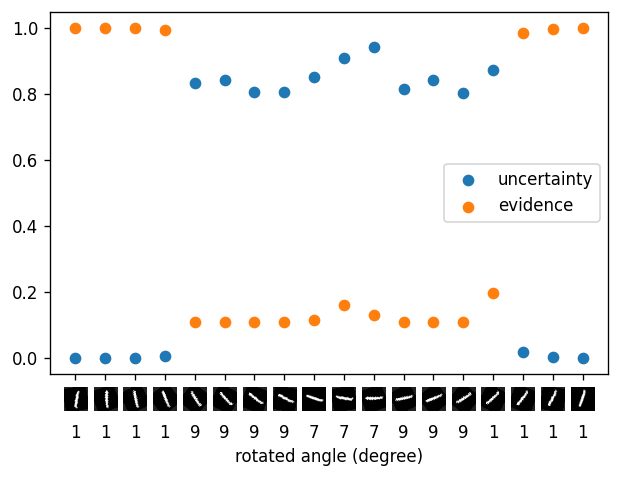

In [20]:
from matplotlib.offsetbox import OffsetImage,AnnotationBbox

def offset_image(coord, index, ax):
    im = OffsetImage(rotated_pics[index].permute(1, 2, 0), zoom=0.5, cmap='gray')
    im.image.axes = ax

    ab = AnnotationBbox(im, (coord, -0.025),  xybox=(0., -20.), frameon=False,
                        xycoords='data',  boxcoords="offset points", pad=0)

    ax.add_artist(ab)

fig, ax = plt.subplots(figsize=(6, 4), dpi=120)
ax.scatter(angles, unc, label='uncertainty')
ax.scatter(angles, evidence, label='evidence')
ax.tick_params(axis='x', which='major', pad=26)

list_of_angles = list(range(10, 190, 10))
for i, c in enumerate(list_of_angles):
    offset_image(c, i, ax)
ax.set_xlabel('rotated angle (degree)')
ax.set_xticks(list_of_angles)
ax.set_xticklabels(prediction)
ax.legend()
plt.show()